# [Advanced] Cohort Analysis - Customer Retention (2)

Management uses it to identify well-performing cohorts and their common traits so they can focus on those customers. Finance can also use it, to a certain extent, for forecasting.

So it's very important to look for the trait that each cohort has through the analysis, and with Python, 

# What is Cohort?

A cohort is a group of customers who had their first purchase in a given time interval (typically months, but this depends on your business model).

Cohorts help understand how a particular group of customers develops over its lifecycle. Questions cohorts may answer are:

- Is there a high churn? (This will be indicated by a low number of follow-up bookings/purchases.)
- Do customers become more engaged over time? (This may be demonstrated by customers booking/purchasing more frequently the longer they stay with you.)

# 1.0 Import Libraries and generate sample Data

In this example, we will craete a custom-made dataset which resembles a real-world dataset

In [13]:
import gc
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import string
import names

(ADJECTIVES, PEOPLE, and PRODUCTS are all capitalized. In Python, this notation is typically used for variables that are static and/or for settings of a module)

In [4]:
# --- Setup Random Data points --- #

ADJECTIVES = [
    'cool','smart','beautiful','funky','dorky', 'babyish', 'back', 'bad', 'baggy', 'bare', 'barren', 'dorky', 'bad',
    'calculating', 'calm', 'candid', 'canine', 'capital', 'carefree', 'hairy', 'half', 'handmade', 'handsome', 'handy',
    'crazy', 'deliberate'
]

# --- Call the function names.get_first_name() 10,000 times and put the unique results into the PEOPLE list --- #
'''
names.get_first_name() gets a random games
'''
PEOPLE = list(set([names.get_first_name().lower() for i in range(10000)]))


PRODUCTS = [
    'airplane','banana','train','bow','map','skull'
]

In [5]:
# --- Build some helper functions --- #

def generate_dummy_names(adj,sub,number_names=10):
    """
    function generates random name combinations of the provided adjectives and subjects
    >>> name_generator(adj=['cool','strong'],sub=['harry','kate'],number_names=3)
    ['cool_harry', 'strong_kate', 'strong_harry', 'cool_kate']
    """
    if number_names > len(adj)*len(sub):
        raise ValueError(f"""
            Can at most genereate {len(adj)*len(sub) -1} names, increase adj or sub to allow for more names
            """)
    res = set()
    while len(res) < number_names:
        new_name = f'{np.random.choice(adj)}_{np.random.choice(sub)}'
        res = res | set([new_name])
    return list(res)

def generate_dummy_order_id(size=16, chars=list(string.ascii_uppercase + string.digits)):
    """
    function generates random order ids
    >>> generate_order_id()
    '0BHSIX003CJKMH2A'
    """
    return ''.join(np.random.choice(chars) for _ in range(size))

def fortmat_quarter(x):
    """
    function turns a datetime into a string representation of the corresponding quarter:
    >>> fortmat_quarter(datetime.datetime(2018,1,3))
    '2018-Q1'
    >>> fortmat_quarter(datetime.datetime(2019,5,3))
    '2019-Q2'
    """
    quarter = (x.month-1)//3 + 1    
    return str(x.year)+'-Q'+str(quarter)

In [6]:
# --- Dummy data function --- #

# we create 15000 fake customer names: ['smart_randy', 'canine_carol', 'carefree_cheryl',  ...]
customers = generate_dummy_names(ADJECTIVES, PEOPLE, 15000)

# we create 10 fake products: ['carefree_skull', 'bare_map', 'calculating_banana', 'funky_train', 'cool_train', ...]
products = generate_dummy_names(ADJECTIVES, PRODUCTS, 10)

In [14]:
# --- Generate the dummy DataFrame --- #
'''
This function generates a sample pandas DataFrame based on dummy_products and dummy_customers. 
There are additional parameters that you can set
'''

def generate_dummy_dataframe(
    dummy_products,
    dummy_customers,
    dummy_customer_types = ['company','private','government'],
    first_date=datetime.datetime(2014,1,1),
    last_date=datetime.datetime(2018,12,31),
    data_points=1000):
    
    customer_type = {customer:np.random.choice(['company','private','government']) for customer in dummy_customers}
    product_prices = {product:np.random.randint(100,10000) for product in dummy_products}

    df = pd.DataFrame({
        'order_id' : [generate_dummy_order_id() for i in range(data_points)],
        'order_date' : [np.random.choice(pd.date_range(first_date,last_date)) for i in range(data_points)],
        'customer' : [np.random.choice(dummy_customers) for i in range(data_points)],
        'product' : [np.random.choice(dummy_products) for i in range(data_points)],
        'order_size': [np.random.randint(1,5) for i in range(data_points)]
    })
    df['customer_type'] = df['customer'].map(customer_type)
    df['product_price'] = df['product'].map(product_prices)
    df['basket_size'] = df['order_size']*df['product_price']
    
    return df

In [16]:
# --- create our dummy DataFrame --- #
df = generate_dummy_dataframe(products, customers)

In [17]:
df.head()

,order_id,order_date,customer,product,order_size,customer_type,product_price,basket_size
0,9AM8H8UQ98VTL14S,2018-05-28,bad_monica,funky_banana,3,company,8145,24435
1,CHGBC6MCRKJLDQVA,2015-12-05,dorky_marion,barren_skull,1,government,8203,8203
2,YNEWQQB18DSUYXUU,2014-01-19,bad_beryl,smart_banana,2,government,1551,3102
3,QSDS997M3JT9IJ54,2016-08-01,handsome_kent,cool_bow,4,private,2449,9796
4,H9MX3SCCJX9ZEON1,2015-10-16,handsome_rolando,carefree_banana,4,government,466,1864


In [18]:
# --- Add a few more varialbes to the dummy data like order types and times of first orders --- #
customer_data = pd.DataFrame(df.groupby('customer')['order_date'].min())
customer_data.columns = ['customer_first_order']
customer_data.head(2)

# --- combine first booking with our dummy data --- #
df = pd.merge(df,customer_data.reset_index(),on='customer')

# --- determine if a order is a repeat order or first order --- #
df['type_of_order'] = np.where(df['order_date'] != df['customer_first_order'], 'repeat', 'first')

In [19]:
df.head()

,order_id,order_date,customer,product,order_size,customer_type,product_price,basket_size,customer_first_order,type_of_order
0,9AM8H8UQ98VTL14S,2018-05-28,bad_monica,funky_banana,3,company,8145,24435,2017-05-01,repeat
1,MSC0T7L6PDTQB2PE,2017-05-01,bad_monica,barren_bow,4,company,5645,22580,2017-05-01,first
2,CHGBC6MCRKJLDQVA,2015-12-05,dorky_marion,barren_skull,1,government,8203,8203,2015-12-05,first
3,YNEWQQB18DSUYXUU,2014-01-19,bad_beryl,smart_banana,2,government,1551,3102,2014-01-19,first
4,QSDS997M3JT9IJ54,2016-08-01,handsome_kent,cool_bow,4,private,2449,9796,2016-08-01,first


# 2.0 How to Build the Function That Generate the Cohorts
We do need some helper functions for the cohort analysis; the following two functions are prefixed with an underscore. In Python, this means that the function is intended for internal use. In our case, theses functions are being called by our actual function generate_cohort_analysis to make said function a little bit more readable.
For now, copy-paste the following code block into your Jupyter Notebook and run the cell. The functions become available, but ignore them for the time being.

In [20]:
def _generate_cohorts(dataset, metric):
    cohorts = dataset.groupby(['cohort','order_period']).agg({
        'order_id':pd.Series.nunique,
        'order_size':sum,
        'basket_size':sum
    })
    cohorts.columns = ['number_of_orders','number_of_items_bought','total_order_value']
    
    cohorts = cohorts[metric].unstack(0)
    
    return cohorts

def _generate_repeat_percentages(dataset,metric):
    repeat_perc = dataset.groupby(['cohort', 'type_of_order']).agg({
        'order_id':pd.Series.nunique,
        'order_size':sum,
        'basket_size':sum
    }).unstack()

    repeat_perc = repeat_perc.stack().T.stack(level=0).fillna(0)
    repeat_perc['percentage repeat'] = repeat_perc['repeat']/repeat_perc.sum(axis=1)
    repeat_perc = repeat_perc.unstack(level=0).iloc[:,-3:]
    
    repeat_perc.columns = ['Orders Repeat %', 'Items Bought Repeat %', 'Order Value Repeat %']

    if metric == 'number_of_orders':
        selection = 'Orders Repeat %'
    if metric == 'number_of_items_bought':
        selection = 'Items Bought Repeat %'
    if metric == 'total_order_value':
        selection = 'Order Value Repeat %'
    if not selection:
        raise NotImplementedError('No repeat figures for specified metric')

    repeat_perc = repeat_perc[selection].reset_index()
    
    return repeat_perc, selection

# 3.0 Visualizations of the Cohorts

You can run it with different parameters you set. To create a cohort analysis you would just run:

In [ ]:
'''
Explain generate_cohort_anlysis parameters:

df :  dummy data we created before,
metric : metric you are curious about (i.e. number_of_orders, number_of_items_bought, or total_order_value) 
record_type(default=all) : subsegment sample data and only look at a specific group (i.e. all, private, company, or government)
period_agg(default= quarterly) : option - monthly or quarterly
fig(default=True) : actual data should be produced
save_fig(default=True) : the resulting plot saved
size(default=10) : size of the annotations

'''

In [22]:
def generate_cohort_analysis(df, metric, record_type='all', period_agg='quarterly', fig=True, size=10, save_fig=True):
    """
    For metric use 'number_of_orders', 'number_of_items_bought'  or 'total_order_value'
    For record_type use 'all' or specific customer_type ['private','company','government']
    no_fig controlls the output of a figure, by default True (i.e. no figure)
    """

    dataset = df.copy()
    if record_type != 'all':
        dataset = df[df.customer_type == record_type].copy()
        
    # format dates (i.e. map customers into their cohort and orders into the respective order period)
    if period_agg=='quarterly':
        dataset['cohort'] = dataset['customer_first_order'].apply(lambda x: fortmat_quarter(x))
        dataset['order_period'] = dataset['order_date'].apply(lambda x: fortmat_quarter(x))
    elif period_agg=='monthly':
        dataset['cohort'] = dataset['customer_first_order'].apply(lambda x: x.strftime('%Y-%m'))
        dataset['order_period'] = dataset['order_date'].apply(lambda x: x.strftime('%Y-%m'))
    else:
        raise NotImplementedError(f'period_agg: {period_agg} is not implemented')
        
    # generate cohorts
    cohorts = _generate_cohorts(dataset,metric)

    # generate new accounts data
    cohort_group_size = dataset.groupby('cohort').agg({'customer': pd.Series.nunique})
    new_accs = cohort_group_size.reset_index()
    new_accs.columns = ['cohort', 'New Accounts']

    # generate repeat data
    repeat_perc, selection = _generate_repeat_percentages(dataset,metric)

    # returns the data and does not plot anything
    if not fig:
        return (cohorts.T.join(new_accs.set_index('cohort')).fillna(0))
    
    #### Plot the Data ####
    # create the figures grid
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 7), gridspec_kw={'width_ratios': (1, 14, 1)})
    sns.despine(left=True, bottom=True, right=True)
    # plot new accounts
    Accounts = sns.barplot(x="New Accounts", y='cohort', data=new_accs, palette="Blues", ax=ax1)

    # plot retention matrix
    Heatmap = sns.heatmap(cohorts.T,
                          cmap="Blues",
                          annot=True,
                          fmt=".0f",
                          annot_kws={"size": size},
                          cbar=False,
                          yticklabels=False,
                          ax=ax2)

    title = 'Retention Matrix for "{}" - for Account Type "{}"'.format(metric, record_type)
    Heatmap.set_title(title)
    Heatmap.yaxis.get_label().set_visible(False)
    Heatmap.set_xlabel('order_period')

    # plot repeat table
    Repeats = sns.barplot(x=selection, y='cohort', data=repeat_perc, palette="Blues", ax=ax3)
    # removes y-axis label
    Repeats.yaxis.get_label().set_visible(False)
    # removes y-axis tickl labels
    Repeats.set(yticklabels=[])
    # removes y-axis ticks themselves
    Repeats.set(yticks=[])
    vals = Repeats.get_xticks()
    Repeats.set_xticklabels(['{:,.0f}%'.format(x * 100) for x in vals])


    # final layout touches

    plt.tight_layout()

    # saves the figure
    if save_fig:
        fig = Heatmap.get_figure()
        fig.savefig(metric+'RetentionMatrix'+record_type+'.png', bbox_inches='tight', dpi=600)

In [25]:
generate_cohort_analysis(df=df, metric='number_of_orders', fig=False)

,2014-Q1,2014-Q2,2014-Q3,2014-Q4,2015-Q1,2015-Q2,2015-Q3,2015-Q4,2016-Q1,2016-Q2,...,2016-Q4,2017-Q1,2017-Q2,2017-Q3,2017-Q4,2018-Q1,2018-Q2,2018-Q3,2018-Q4,New Accounts
cohort,,,,,,,,,,,,,,,,,,,,,
2014-Q1,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50
2014-Q2,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,51
2014-Q3,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,52
2014-Q4,0.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,46
2015-Q1,0.0,0.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46
2015-Q2,0.0,0.0,0.0,0.0,0.0,57.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,57
2015-Q3,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,42
2015-Q4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,54
2016-Q1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50


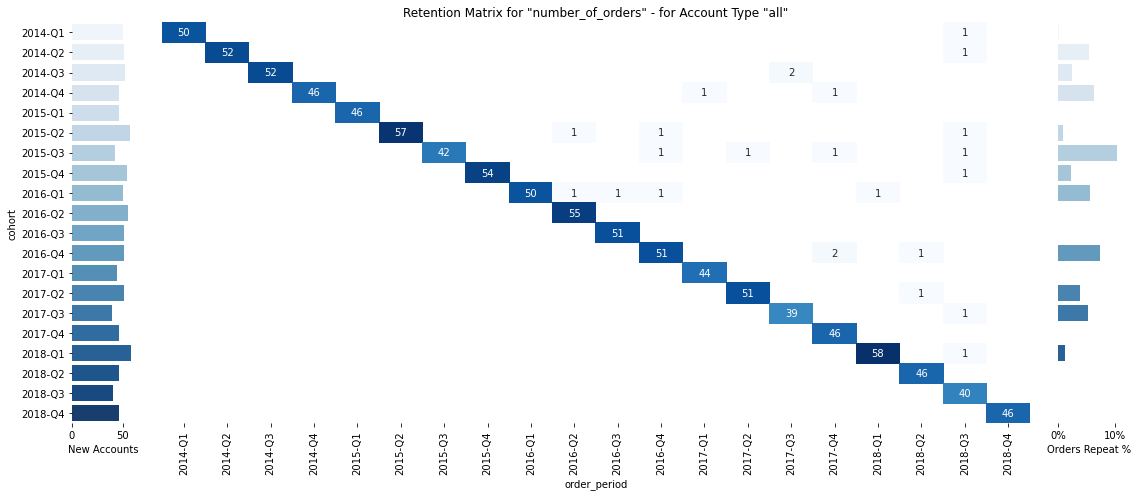

In [24]:
generate_cohort_analysis(df=df, metric='number_of_orders', fig=True)

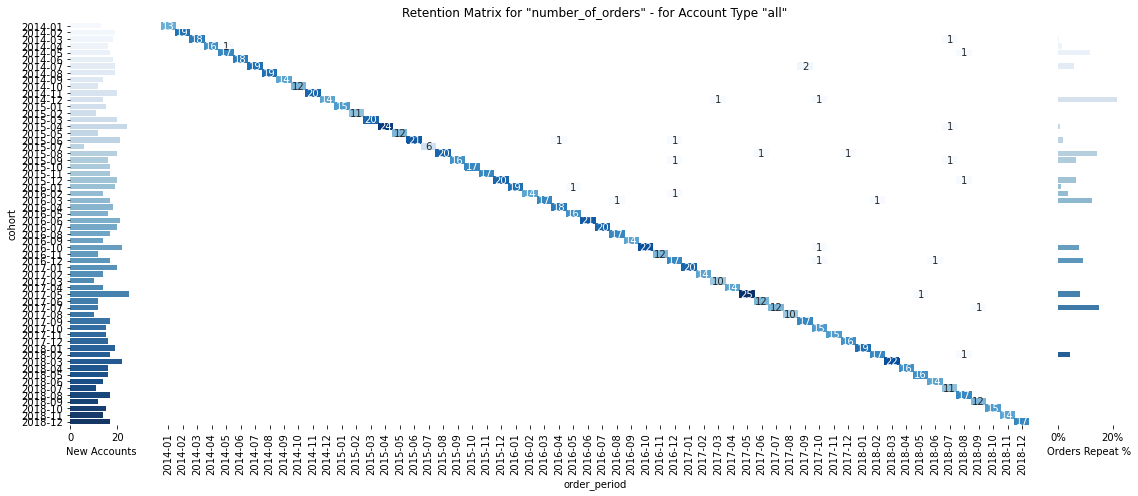

In [26]:
generate_cohort_analysis(df=df, metric='number_of_orders', period_agg='monthly')

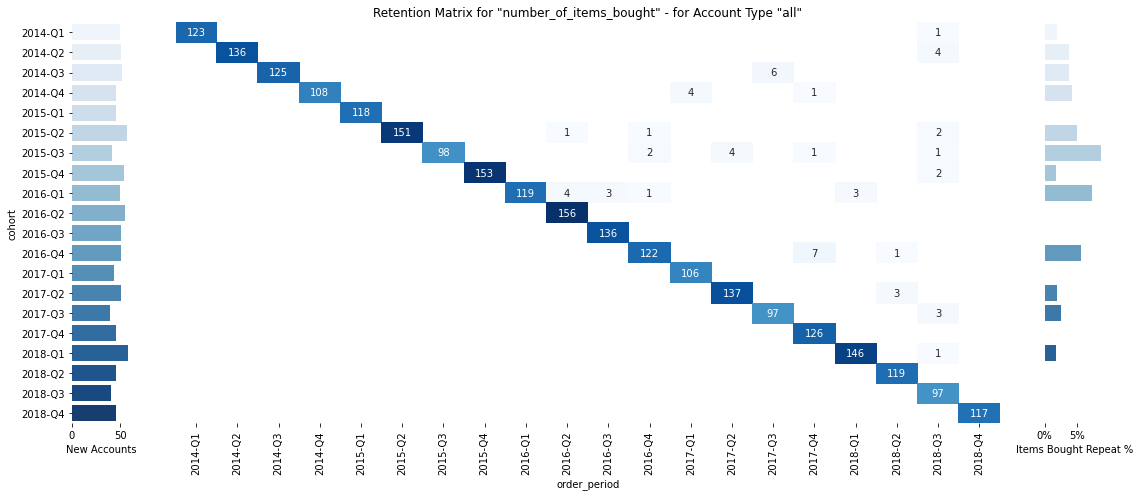

In [27]:
generate_cohort_analysis(df=df, metric='number_of_items_bought')

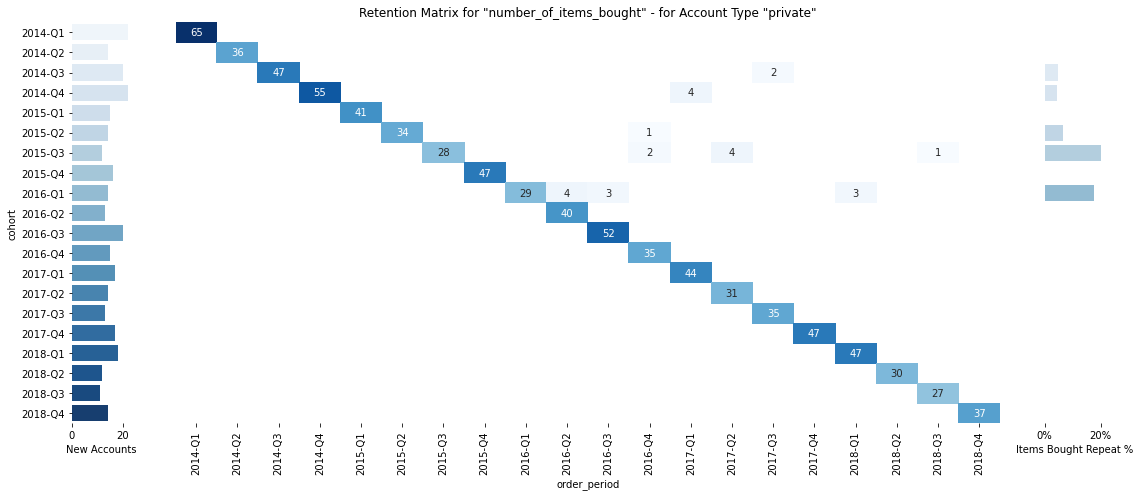

In [28]:
generate_cohort_analysis(df=df, metric='number_of_items_bought', record_type='private')

Reference:
https://medium.com/better-programming/cohort-analysis-with-python-e81d9d740a9b